# Alimama International Search Ads CTR Algorithms Competition
- Our team achieved Top 18% from 5204 teams.
- This document is not the original one, is a result after we review the top solutions in open source and extract good ideas from them(will be listed), say feature engineering and data ensemble methods(Stacking, Boosting, Bagging).



#### Reference(Thanks to):
- [Website of Comletition](https://tianchi.aliyun.com/competition/introduction.htm?spm=5176.100067.5678.1.65832163R57OeU&raceId=231647)
- [bettenW](https://github.com/bettenW/IJCAI18_Tianchi_Rank29)
- [plantsgo](https://github.com/plantsgo/ijcai-2018)
- [藍鯨烧香隊](https://github.com/YouChouNoBB/ijcai-18-top2-single-mole-solution)
- [shenweichen](https://github.com/shenweichen/IJCAI_2018_Competition_baseline)
- [classtag](https://github.com/classtag/ijcai18-mama-ads-competition)

---
- Team: Datababa 
- Member: Xiaoshuai Jin; Lucas Xu; Akasi Shang
... 

In [ ]:
# 1. Data Importing

In [1]:
import csv
import numpy as np
from numpy import loadtxt
import pandas as pd
import os
from matplotlib import pyplot
from matplotlib import style
style.use("ggplot")
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
import datetime
import time
import _thread
import gc
import lightgbm
import xgboost as xgb
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from mlxtend.classifier import StackingClassifier
import warnings
warnings.filterwarnings("ignore")

start = time.time()
ads = pd.read_csv('./train_clean.csv')
ads.shape

(477147, 27)

# 2. Feature Engineering

In [2]:
##===============================   2.1 Time Related- Statistic Features   ==============================##


def datetime_timestamp(ts):
    """
    To Convert unix timestamp to format
    """
    temp = time.localtime(ts)
    date_time = time.strftime('%Y-%m-%d %H:%M:%S', temp)
    return date_time

def timestamp_cvt(data):
    """
    Extract detailed time from timestamp
    """
    data['time'] = data['context_timestamp'].apply(datetime_timestamp)
    data['day'] = data['time'].apply(lambda x: int(x[8:10]))
    data['hour'] = data['time'].apply(lambda x: int(x[11:13]))
    return data

def search_count(data):
    """
    Add fea of hourly and daily searches count for each user.
    """
    cnt_day = data.groupby(['user_id', 'day']).size()
    query_day = cnt_day.reset_index().rename(columns={0: 'user_query_day'})
    #then merge the fea to the main data
    data = data.merge(query_day, on=['user_id', 'day'], how='left')
    
    cnt_day_hour = data.groupby(['user_id', 'day', 'hour']).size()
    query_day_hour = cnt_day_hour.reset_index().rename(columns={0: 'user_query_day_hour'})
    data = data.merge(query_day_hour, on=['user_id', 'day', 'hour'], how='left')
    
    del cnt_day, query_day, cnt_day_hour, query_day_hour
    gc.collect()
    return data

def shop_mean_age(data):
    """
    To creat fea of average age in shops
    """
    shop_mean_age = data.groupby('shop_id')['user_age_level'].mean().reset_index()
    shop_mean_age.columns = ['shop_id', 'shop_mean_age']
    data = data.merge(shop_mean_age, on=['shop_id'], how='left')
    del shop_mean_age
    gc.collect()
    return data

ads = timestamp_cvt(ads)
ads = search_count(ads)
ads = shop_mean_age(ads)

In [3]:
##all 6 days count, little impact

# def dolastCount(data):
#     """
#     To count the ids('shop_id',tec.) that are not in the last day
#     
#     But little impact, will be dropped finally
#     """
#     keys = ['shop_id', 'item_id', 'user_id', 'item_brand_id', 'item_city_id', 'item_sales_level']
#     for colname in keys:
#         print(colname,'starting.....')
#         count = data.groupby([colname]).apply(lambda x: x['instance_id'][(x['day']!=7).values].count()).reset_index(name='cnt_'+colname)
#         sums = data.groupby([colname]).apply(lambda x: x['item_sales_level'][(x['day']!=7).values].sum()).reset_index(name='sum_'+colname)
#         data = pd.merge(data,count, how='left', on=[colname])
#         data = pd.merge(data,sums, how='left', on=[colname])
    
#     for colname in keys:
#         if(colname != 'user_id'):
#             print(colname,'starting.....')
#             count = data.groupby([colname, 'user_id']).apply(lambda x: x['instance_id'][(x['day']!=7).values].count()).reset_index(name='cnt_'+'user_id_'+colname)
#             sums = data.groupby([colname, 'user_id']).apply(lambda x: x['item_sales_level'][(x['day']!=7).values].sum()).reset_index(name='sum_'+'user_id_'+colname)
#             data = pd.merge(data,count, how='left', on=[colname, 'user_id'])
#             data = pd.merge(data,sums, how='left', on=[colname, 'user_id'])
    
#     data['item_user_ratio'] = data['cnt_user_id_item_id']/data['cnt_user_id']
#     data['shop_user_ratio'] = data['cnt_user_id_shop_id']/data['cnt_user_id']
#     data['brand_user_ratio'] = data['cnt_user_id_item_brand_id']/data['cnt_user_id'] 

#     return data

# ads = dolastCount(ads)

In [4]:
##===============================   2.2 Time Related-TopN   ==============================##
### This is find active feas.
### Grouped by day, hour, or day_hour; the below are filtered ones after many tests

def topN_user_city(data):
    """
    Num of active cities given user_id and hour
    """
    temp = pd.DataFrame(data.groupby(["user_id", "hour"]).item_city_id.nunique()).reset_index()
    temp.columns = ["user_id", "hour", "user_hour_active_city"]
    data = data.merge(temp, on=["user_id", "hour"], how="left")
    del temp
    gc.collect()
    return data

def topN_user_shop(data):
    """
    Num of active shops given user_id and hour
    """
    temp = pd.DataFrame(data.groupby(["user_id", "day", "hour"]).shop_id.nunique()).reset_index()
    temp.columns = ["user_id", "day", "hour", "user_day_hour_active_shop"]
    data = data.merge(temp, on=["user_id", "day", "hour"], how="left")
    del temp
    gc.collect()
    return data

def topN_user_brand(data):
    """
    Num of active brands given user_id and hour
    """
    temp = pd.DataFrame(data.groupby(["user_id", "hour"]).item_brand_id.nunique()).reset_index()
    temp.columns = ["user_id", "hour", "user_hour_active_brand"]
    data = data.merge(temp, on=["user_id", "hour"], how="left")
    del temp
    gc.collect()
    return data

def topN_brand_user(data):
    """
    Num of active users given brand and hour
    """
    temp = pd.DataFrame(data.groupby(["item_brand_id", "day"]).user_id.nunique()).reset_index()
    temp.columns = ["item_brand_id", "day", "brand_day_active_user"]
    data = data.merge(temp, on=["item_brand_id","day"], how="left")
    del temp
    gc.collect()
    return data

def topN_cat_user(data):
    """
    Num of active users given categories and hour
    """
    temp = pd.DataFrame(data.groupby(["item_category_list", "hour"]).user_id.nunique()).reset_index()
    temp.columns = ["item_category_list", "hour", "category_hour_active_user"]
    data = data.merge(temp, on=["item_category_list", "hour"], how="left")
    del temp
    gc.collect()
    return data

def topN_shop_user(data):
    """
    Num of active users given cities given and hour
    """
    temp = pd.DataFrame(data.groupby(["shop_id", "hour"]).user_id.nunique()).reset_index()
    temp.columns = ["shop_id", "hour", "shop_hour_active_user"]
    data = data.merge(temp, on=["shop_id", "hour"], how="left")
    del temp
    gc.collect()
    return data



ads = topN_user_city(ads)
ads = topN_user_shop(ads)
ads = topN_user_brand(ads)
ads = topN_brand_user(ads)
ads = topN_cat_user(ads)
ads = topN_shop_user(ads)

In [5]:
# # 先留着，待会删去

# # 活跃city数特征  
# add = pd.DataFrame(ads.groupby(["user_id", "hour"]).item_city_id.nunique()).reset_index()
# add.columns = ["user_id", "hour", "user_hour_active_city"]
# ads = ads.merge(add, on=["user_id", "hour"], how="left")
# del add
# gc.collect()

# # # # 活跃shop数特征  78323
# add = pd.DataFrame(ads.groupby(["user_id", "day", "hour"]).shop_id.nunique()).reset_index()
# add.columns = ["user_id", "day", "hour", "user_day_hour_active_shop"]
# ads = ads.merge(add, on=["user_id", "day", "hour"], how="left")
# del add
# gc.collect()

# # # # 活跃brand数特征  7829
# add = pd.DataFrame(ads.groupby(["user_id", "hour"]).item_brand_id.nunique()).reset_index()
# add.columns = ["user_id", "hour", "user_hour_active_brand"]
# ads = ads.merge(add, on=["user_id", "hour"], how="left")
# del add
# gc.collect()

# #  #活跃brand_user数特征   78478
# add = pd.DataFrame(ads.groupby(["item_brand_id", "day"]).user_id.nunique()).reset_index()
# add.columns = ["item_brand_id", "day", "brand_day_active_user"]
# ads = ads.merge(add, on=["item_brand_id","day"], how="left")
# del add
# gc.collect()

# # #活跃category_user数特征   7841
# add = pd.DataFrame(ads.groupby(["item_category_list", "hour"]).user_id.nunique()).reset_index()
# add.columns = ["item_category_list", "hour", "category_hour_active_user"]
# ads = ads.merge(add, on=["item_category_list", "hour"], how="left")
# del add
# gc.collect()

# #shop_user   78481
# add = pd.DataFrame(ads.groupby(["shop_id", "hour"]).user_id.nunique()).reset_index()
# add.columns = ["shop_id", "hour", "shop_hour_active_user"]
# ads = ads.merge(add, on=["shop_id", "hour"], how="left")

# del add
# gc.collect()

In [6]:
##===============================   2.3 Time Related-Roll Window&time gap   ==============================##

def roll_window(data):
    """
    Roll window, to mark how many times this user has checked a certain time before current time;

    and mark the opposite one, how many after the current context time(but this is meaning less in real world)
    """
    #prepare, mark the timestamp
    data['context_timestamp_str'] = data['context_timestamp'].astype(str)
    
    group_temp1 = data.groupby('user_id')['context_timestamp_str']
    user_time_join = group_temp1.agg(lambda x:';'.join(x)).reset_index()
    user_time_join.rename(columns={'context_timestamp_str':'user_time_join'},inplace = True)
    data = data.merge(user_time_join, on=['user_id'], how='left')
    
    group_temp2 = data.groupby(['user_id','shop_id'])['context_timestamp_str']
    user_shop_time_join = group_temp2.agg(lambda x:';'.join(x)).reset_index()
    user_shop_time_join.rename(columns={'context_timestamp_str':'user_shop_time_join'},inplace = True)
    data = data.merge(user_shop_time_join,on=['user_id','shop_id'],how='left')
    
    group_temp3 = data.groupby(['user_id','item_id'])['context_timestamp_str']
    user_item_time_join = group_temp3.agg(lambda x:';'.join(x)).reset_index()
    user_item_time_join.rename(columns={'context_timestamp_str':'user_item_time_join'},inplace = True)
    data = data.merge(user_item_time_join,on=['user_id','item_id'],how='left')
    
    data['index_']=data.index
    del user_time_join, user_shop_time_join, user_item_time_join
    gc.collect()
    
    nowtime=data['context_timestamp'].values
    user_time=data['user_time_join'].values
    user_shop_time=data['user_shop_time_join'].values
    user_item_time=data['user_item_time_join'].values
    
    empty_arr = np.zeros(data.shape[0])
    user_time_bf = empty_arr
    user_time_af = empty_arr
    user_shop_time_bf = empty_arr
    user_shop_time_af = empty_arr
    user_item_time_bf = empty_arr
    user_item_time_af = empty_arr
    
    time_gap = 1150   #half of time window,1150s is obtained after many tests
    
    for i in range(data.shape[0]):
        df1 = nowtime[i]
        df2 = user_time[i].split(';')
        df2_len=len(df2)
        for j in range(df2_len):
            if ((int(df2[j])-df1)<time_gap) & ((int(df2[j])-df1)>0):
                user_time_bf[i]+=1
            if ((int(df2[j])-df1)>-time_gap) & ((int(df2[j])-df1)<0):
                user_time_af[i]+=1
        
        df3=user_shop_time[i].split(';')
        df3_len=len(df3)
        for j in range(df3_len):
            if ((int(df3[j])-df1)<time_gap) & ((int(df3[j])-df1)>0):
                user_shop_time_bf[i]+=1
            if ((int(df3[j])-df1)>-time_gap) & ((int(df3[j])-df1)<0):
                user_shop_time_af[i]+=1
                
        df4=user_item_time[i].split(';')
        df4_len=len(df4)
        for j in range(df4_len):
            if ((int(df4[j])-df1)<time_gap) & ((int(df4[j])-df1)>0):
                user_item_time_bf[i]+=1
            if ((int(df4[j])-df1)>-time_gap) & ((int(df4[j])-df1)<0):
                user_item_time_af[i]+=1
                
    data['user_count_bf'] = user_time_bf
    data['user_count_af'] = user_time_af   
    data['user_shop_count_bf'] = user_shop_time_bf
    data['user_shop_count_af'] = user_shop_time_af
    data['user_item_count_bf'] = user_item_time_bf
    data['user_item_count_af'] = user_item_time_af

    drops = ['context_timestamp_str', 'user_time_join', 'user_shop_time_join',
       'user_item_time_join', 'index_']
    data = data.drop(drops, axis=1)
    
    del user_time_bf, user_time_af, user_shop_time_bf, 
    del user_shop_time_af, user_item_time_bf, user_item_time_af
    del user_time, user_shop_time, user_item_time
    gc.collect()
    return data

ads = roll_window(ads)

In [7]:
def mark_click_order(data):
    """
    To mark the first, the last and the middle click,
    
    we discussed user just loggin, click certain item, certain brand and certain shop 
    """
    data.sort_values(['user_id', 'context_timestamp'], inplace=True)
    
    #user click any within one day
    subset = ['user_id', 'day'] 
    data['click_user_lab'] = 0
    pos = data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_lab'] = 1
    pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_lab'] = 2   #first marks 2
    pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_lab'] = 3   #last marks 3
    del pos
    gc.collect()

    #user click same item within one day
    subset = ['item_id', 'user_id', 'day']  
    data['click_user_item_lab'] = 0
    pos = data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_item_lab'] = 1
    pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_item_lab'] = 2
    pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_item_lab'] = 3
    del pos
    gc.collect()

    #user click same brand within one day
    subset = ['item_brand_id','user_id', 'day'] 
    data['click_user_brand_lab'] = 0
    pos = data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_brand_lab'] = 1
    pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_brand_lab'] = 2
    pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_brand_lab'] = 3
    del pos
    gc.collect()

    #user click same shop, within one day
    subset = ['shop_id','user_id', 'day']   
    data['click_user_shop_lab'] = 0
    pos = data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_shop_lab'] = 1
    pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_shop_lab'] = 2
    pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
    data.loc[pos, 'click_user_shop_lab'] = 3
    del pos
    gc.collect()

    return data


def last_diff(data):
    """
    To record how long since last click, very useful.
    
    Did not include the opposite, because we cannot grab this data in real work flow.
    """
    for column in ['user_id', 'item_id']:
        gc.collect()
        data[column+'_lasttime_diff'] = 0
        train_data = data[['context_timestamp', column, column+'_lasttime_diff']].values
        lasttime_dict = {}
        for df_list in train_data:
            if df_list[1] not in lasttime_dict:
                df_list[2] = -1
                lasttime_dict[df_list[1]] = df_list[0]
            else:
                df_list[2] = df_list[0] - lasttime_dict[df_list[1]]
                lasttime_dict[df_list[1]] = df_list[0]
        data[['context_timestamp', column, column+'_lasttime_diff']] = train_data
    return data

ads = mark_click_order(ads)
ads = last_diff(ads)

In [8]:
##===============================   2.4 Feature Interaction  ==============================##
##- little impact, say ratio of collection and sales, or pv level
## other ratio features are not that good 

In [9]:
##===============================   2.5 Other Features   ==============================##

def com_ppt(data):
    """
    To compare text parse result and item property,
    
    if higher similarity, higher value
    """
    ppt = data['item_property_list'].str.split(';',expand=True)
    temp = pd.DataFrame(np.zeros((ppt.shape[0],1), dtype=int), columns=['compare_ppt'])
    for i in range(0, ppt.shape[0]):
        val = 0
        for j in range(0, ppt.shape[1]):
            if ppt.loc[i, j] is None: pass
            elif ppt.loc[i, j] not in data.loc[i,'predict_category_property']: pass
            else: val = val + 1
        temp.loc[i, 'compare_ppt'] = val
    data.insert(15, 'compare_ppt', temp['compare_ppt'])
    del temp, ppt
    gc.collect()
    return data

ads = com_ppt(ads)

# 3. Model Training
#### 3.1 XGBoost
- xgb简介和特点 https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None,**kwargs)
- 调参：除了别人上面已经提到的GridSearch和RandomSearch，我再说个稍微邪门一点的方法。用RandomForest，
xgboost有很多优势，以及与传统的gbdt算法有一些不同的地方：

1、正则项，xgboost中添加了正则项，如果读过我之前文章的人应该清楚xgboost中的正则项是包括哪两个部分，他们分别是叶子结点数和叶子结点的分数，取叶子结点数比较好理解，相当于控制了数的复杂度，但是为什么会把叶子结点的分数作为正则项放进来呢，可以好好思考一下这个问题，答案与决策树的性质有一定关系，后续有机会再讲；

2、并行化计算，xgboost相比sklearn中的gbdt，速度有明显的提升，正是因为并行化计算，具体原理可以看陈天奇的那篇论文，这里略过；

3、损失函数可自定义，xgboost支持自己定义的损失函数，只要满足二阶可导即可；

4、自行处理缺失值，xgboost处理缺失值完全是按照cv的方法，分到左边或右边，哪个收益高，分到哪边；

5、树分裂的停止条件更合理，传统的gbdt中，可能当某节点继续分裂产生负向的收益就停止了，而xgboost会继续往下分裂，因为由于变量之间的互相影响，后续可能会带来正向的收益并完全弥补前一处分裂带来的负向收益，所以一部分采用了后剪枝的思想；

6、迭代cv，xgboost支持输入验证集，每步迭代时都会输出对验证集的预测效果；
#### 3.2 LightGB
xgb简介和特点
#### 3.3 Logistics Regression

In [10]:
train = ads.loc[ads.day < 24]  # use 18-13 date as train data
test = ads.loc[ads.day == 24]  # use the last day as test, we did not use random split here

features = ['item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
            'item_collected_level', 'item_pv_level', 'user_gender_id',
            'user_age_level', 'user_occupation_id', 'user_star_level',
            'context_page_id', 'shop_id', 'shop_review_num_level', 
            'shop_review_positive_rate','shop_star_level', 'shop_score_service',
            'shop_score_delivery', 'shop_score_description','hour', 'user_query_day', 
            'user_query_day_hour','compare_ppt', 
            'shop_mean_age',
            'user_hour_active_city', 'user_day_hour_active_shop', 'user_hour_active_brand',
            'brand_day_active_user', 'category_hour_active_user', 'shop_hour_active_user', 
            'user_count_bf', 'user_count_af', 'user_shop_count_bf', 
            'user_shop_count_af', 'user_item_count_bf', 'user_item_count_af',
            'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab', 
            'click_user_shop_lab', 'user_id_lasttime_diff', 'item_id_lasttime_diff',
           ]
target = ['is_trade']

X_train, X_test, Y_train, Y_test = train[features], test[features], train[target], test[target]

[0]	validation_0-logloss:0.679006
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.665297
[2]	validation_0-logloss:0.651968
[3]	validation_0-logloss:0.639045
[4]	validation_0-logloss:0.626492
[5]	validation_0-logloss:0.614299
[6]	validation_0-logloss:0.602436
[7]	validation_0-logloss:0.590918
[8]	validation_0-logloss:0.579715
[9]	validation_0-logloss:0.568818
[10]	validation_0-logloss:0.558209
[11]	validation_0-logloss:0.547892
[12]	validation_0-logloss:0.537827
[13]	validation_0-logloss:0.528052
[14]	validation_0-logloss:0.518514
[15]	validation_0-logloss:0.509215
[16]	validation_0-logloss:0.500149
[17]	validation_0-logloss:0.491383
[18]	validation_0-logloss:0.482877
[19]	validation_0-logloss:0.47451
[20]	validation_0-logloss:0.466338
[21]	validation_0-logloss:0.458338
[22]	validation_0-logloss:0.450532
[23]	validation_0-logloss:0.442897
[24]	validation_0-logloss:0.435456
[25]	validation_0-logloss:0.428197
[26]	validation_0-logloss:0.4211

[230]	validation_0-logloss:0.084101
[231]	validation_0-logloss:0.083971
[232]	validation_0-logloss:0.083844
[233]	validation_0-logloss:0.083722
[234]	validation_0-logloss:0.083601
[235]	validation_0-logloss:0.083481
[236]	validation_0-logloss:0.083361
[237]	validation_0-logloss:0.083243
[238]	validation_0-logloss:0.083129
[239]	validation_0-logloss:0.083016
[240]	validation_0-logloss:0.082907
[241]	validation_0-logloss:0.082795
[242]	validation_0-logloss:0.082691
[243]	validation_0-logloss:0.082589
[244]	validation_0-logloss:0.082493
[245]	validation_0-logloss:0.082394
[246]	validation_0-logloss:0.0823
[247]	validation_0-logloss:0.082206
[248]	validation_0-logloss:0.082113
[249]	validation_0-logloss:0.082023
[250]	validation_0-logloss:0.081931
[251]	validation_0-logloss:0.081843
[252]	validation_0-logloss:0.081754
[253]	validation_0-logloss:0.081668
[254]	validation_0-logloss:0.081587
[255]	validation_0-logloss:0.081507
[256]	validation_0-logloss:0.081431
[257]	validation_0-logloss:0.0

[459]	validation_0-logloss:0.077097
[460]	validation_0-logloss:0.077096
[461]	validation_0-logloss:0.077091
[462]	validation_0-logloss:0.077089
[463]	validation_0-logloss:0.077089
[464]	validation_0-logloss:0.077085
[465]	validation_0-logloss:0.077081
[466]	validation_0-logloss:0.077073
[467]	validation_0-logloss:0.077065
[468]	validation_0-logloss:0.07706
[469]	validation_0-logloss:0.077057
[470]	validation_0-logloss:0.077052
[471]	validation_0-logloss:0.077047
[472]	validation_0-logloss:0.07704
[473]	validation_0-logloss:0.077038
[474]	validation_0-logloss:0.077035
[475]	validation_0-logloss:0.077034
[476]	validation_0-logloss:0.077029
[477]	validation_0-logloss:0.077025
[478]	validation_0-logloss:0.077021
[479]	validation_0-logloss:0.077019
[480]	validation_0-logloss:0.077016
[481]	validation_0-logloss:0.077014
[482]	validation_0-logloss:0.077009
[483]	validation_0-logloss:0.077004
[484]	validation_0-logloss:0.077001
[485]	validation_0-logloss:0.076999
[486]	validation_0-logloss:0.0

[688]	validation_0-logloss:0.076649
[689]	validation_0-logloss:0.07665
[690]	validation_0-logloss:0.076647
[691]	validation_0-logloss:0.076647
[692]	validation_0-logloss:0.076649
[693]	validation_0-logloss:0.076646
[694]	validation_0-logloss:0.07665
[695]	validation_0-logloss:0.076649
[696]	validation_0-logloss:0.076648
[697]	validation_0-logloss:0.076643
[698]	validation_0-logloss:0.076643
[699]	validation_0-logloss:0.076643
[700]	validation_0-logloss:0.076642
[701]	validation_0-logloss:0.076642
[702]	validation_0-logloss:0.076641
[703]	validation_0-logloss:0.076642
[704]	validation_0-logloss:0.076643
[705]	validation_0-logloss:0.07664
[706]	validation_0-logloss:0.076647
[707]	validation_0-logloss:0.076645
[708]	validation_0-logloss:0.076644
[709]	validation_0-logloss:0.076643
[710]	validation_0-logloss:0.076642
[711]	validation_0-logloss:0.076642
[712]	validation_0-logloss:0.076641
[713]	validation_0-logloss:0.076639
[714]	validation_0-logloss:0.07664
[715]	validation_0-logloss:0.076

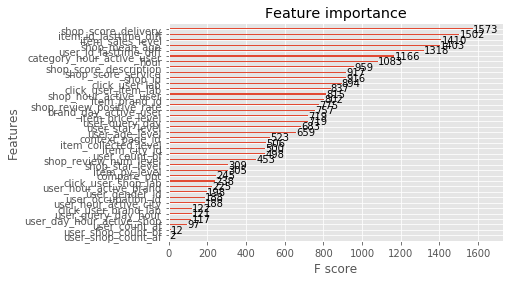

In [13]:
def xgb_model(train_data, train_label, test_data, test_label):
    clf = XGBClassifier(
        n_estimators=851, colsample_bytree=0.8437,
        learning_rate=0.0153, max_depth=5, 
        reg_alpha=0.826, subsample=0.9075)
    clf.fit(train_data, train_label, eval_metric='logloss', 
            eval_set=[(test_data, test_label)], early_stopping_rounds=100)
    Y_pred = clf.predict_proba(X_test)    
    print("logloss", log_loss(Y_test, Y_pred))
    plot_importance(clf)
    pyplot.show()
    return clf

#train and see importance
xgb = xgb_model(X_train,Y_train, X_test,  Y_test)
clf1 = xgb

[1]	valid_0's binary_logloss: 0.63777
Train until valid scores didn't improve in 100 rounds.
[2]	valid_0's binary_logloss: 0.58871
[3]	valid_0's binary_logloss: 0.544978
[4]	valid_0's binary_logloss: 0.505897
[5]	valid_0's binary_logloss: 0.470731
[6]	valid_0's binary_logloss: 0.438912
[7]	valid_0's binary_logloss: 0.41013
[8]	valid_0's binary_logloss: 0.383929
[9]	valid_0's binary_logloss: 0.36006
[10]	valid_0's binary_logloss: 0.338292
[11]	valid_0's binary_logloss: 0.318337
[12]	valid_0's binary_logloss: 0.300069
[13]	valid_0's binary_logloss: 0.283277
[14]	valid_0's binary_logloss: 0.267838
[15]	valid_0's binary_logloss: 0.253636
[16]	valid_0's binary_logloss: 0.240517
[17]	valid_0's binary_logloss: 0.228411
[18]	valid_0's binary_logloss: 0.217179
[19]	valid_0's binary_logloss: 0.20688
[20]	valid_0's binary_logloss: 0.197346
[21]	valid_0's binary_logloss: 0.188509
[22]	valid_0's binary_logloss: 0.180316
[23]	valid_0's binary_logloss: 0.17279
[24]	valid_0's binary_logloss: 0.165758


[200]	valid_0's binary_logloss: 0.0765756
[201]	valid_0's binary_logloss: 0.076581
[202]	valid_0's binary_logloss: 0.0765826
[203]	valid_0's binary_logloss: 0.0765802
[204]	valid_0's binary_logloss: 0.0765676
[205]	valid_0's binary_logloss: 0.0765676
[206]	valid_0's binary_logloss: 0.0765555
[207]	valid_0's binary_logloss: 0.0765527
[208]	valid_0's binary_logloss: 0.0765496
[209]	valid_0's binary_logloss: 0.0765405
[210]	valid_0's binary_logloss: 0.0765452
[211]	valid_0's binary_logloss: 0.0765385
[212]	valid_0's binary_logloss: 0.0765424
[213]	valid_0's binary_logloss: 0.0765451
[214]	valid_0's binary_logloss: 0.0765454
[215]	valid_0's binary_logloss: 0.0765411
[216]	valid_0's binary_logloss: 0.0765359
[217]	valid_0's binary_logloss: 0.0765375
[218]	valid_0's binary_logloss: 0.0765411
[219]	valid_0's binary_logloss: 0.0765328
[220]	valid_0's binary_logloss: 0.0765328
[221]	valid_0's binary_logloss: 0.0765279
[222]	valid_0's binary_logloss: 0.0765261
[223]	valid_0's binary_logloss: 0.0

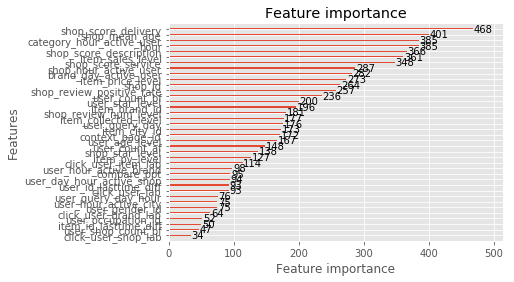

In [15]:
def lgb_model(X_train,Y_train, X_test,  Y_test):
    """
    The params are obtained by long time hyperparameter tunning.
    """
    clf = lightgbm.LGBMClassifier(
        n_estimators=396, colsample_bytree=0.448, 
        learning_rate=0.0613, max_depth=5, 
        reg_alpha=0.7267, subsample=0.8797)   
    clf.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], 
            eval_metric='logloss',early_stopping_rounds=100) 
    Y_pred = clf.predict_proba(X_test)
    print("logloss", log_loss(Y_test, Y_pred))
    lightgbm.plot_importance(clf)
    pyplot.show()
    return clf

lgb = lgb_model(X_train,Y_train, X_test,  Y_test)
clf2 = lgb

# 4. Ensemble Model
- In this part, we will try to use ensemble models, both bagging and stacking, to improve the final result.
- Althrough in this **validation dataset** the loss increases after ensembling, but what we need to focus is result on **test dataset**.

In [16]:
# clf1 = XGBClassifier(
#     n_estimators=851, colsample_bytree=0.8437,
#     learning_rate=0.0153, max_depth=5, 
#     reg_alpha=0.826, subsample=0.9075,)
# clf1.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], 
#         eval_metric='logloss',early_stopping_rounds=100)

# clf2 = lightgbm.LGBMClassifier(
#     n_estimators=396, colsample_bytree=0.448, 
#     learning_rate=0.0613, max_depth=5, 
#     reg_alpha=0.7267, subsample=0.8797, silent = False,)
# clf2.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], 
#         eval_metric='logloss',early_stopping_rounds=100)

clf3 = KNeighborsClassifier(n_neighbors=5)
clf3.fit(X_train, Y_train)

##===============================   4.1 Bagging   ==============================##
eclf_bagging = VotingClassifier(
    estimators=[('xgb', clf1), ('lgb', clf2), ('knn', clf3)], 
    voting='soft', weights=[2,1,2])
eclf_bagging.fit(X_train, Y_train)

##===============================   4.2 Stacking   ==============================##
meta = LogisticRegression(
    C=1.0,penalty='l1',
    tol=0.001,
    max_iter=200, 
    verbose=True)
eclf_stacking = StackingClassifier(
    classifiers=[clf1, clf2, clf3], 
    use_probas=True, 
    average_probas=False,
    meta_classifier=meta)
eclf_stacking.fit(X_train, Y_train)

for clf, model in zip(
    [clf1, clf2, clf3, eclf_bagging, eclf_stacking], 
    ['XGB', 'LGB', 'KNN', 'Ensemble_bagging', 'Ensemble_stacking']):
    Y_pred = clf.predict_proba(X_test)
    print("Model:%s, logloss %0.5f"%(model, log_loss(Y_test, Y_pred)))

[LibLinear]Model:XGB, logloss 0.07660
Model:LGB, logloss 0.07646
Model:KNN, logloss 0.48982
Model:Ensemble_bagging, logloss 0.08144
Model:Ensemble_stacking, logloss 0.10400


In [18]:
print(time.time()-start)
del ads, X_train, X_test, Y_train, Y_test 
gc.collect()

2924.1407418251038


19579

# Summary
#### Data Cleaning:
- Cleaned data brings much higher model performance.

#### Feature Engineering:
- Statistical time-based features are most impactful in this ctr tast.
- Also we have many other kinds of features.

#### Data Modeling:
- With much less cost time, LGB achieves relatively good loss.
- In the parameter tuning process, random search consumes less time and obtains much better loss value, performs much better than TPE(Tree-structured Parzen Estimator) and SAA (Simulate Anneal Arithmetic) in this problem.
- Model ensemble is very important for modeling, it can corrdinate different character of sigle models; but what we need make the base classifiers diverse, which is not showed well in this example.